# Deriving conclusions from clinical research using Clustering

In clinical studies comparing two or more treatment options, subjective and objective outcomes measures are often used to determine which treatment option is better. Mean outcome scores are compared between two treatment options. The treatment option with the SIGNIFICANTLY highest mean outcome scores is determined to be the best treatment.

This approach is based on traditional statistical approach of hypothesis formulation and testing.

Recent advances in methods of dealing with big data have changed the traditional statistical thinking. Having a lot of data, scientists now observe patterns of data and based on these patterns they either derive conclusions or formulate hypotheses for further research. 

In this exercise we will inspect data of patients who had one of the two types of surgery for shoulder instability. 

With the latter approach we can better compare between different patients because we can simultaneously evaluate several outcome measures (i.e. mental health together with physical outcome) and to account for their components (i.e. in functional assessment to account for different scores for pain and range of motion even if total score is similar).

One point that may be overlooked in clinical research is focus on patients who did not do well.
We can also investigate for causes of adverse outcomes in these patients.

In [179]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [180]:
df = pd.read_csv('UNITED_ENG.csv')

In [181]:
df['Date_hospitalization'] = pd.to_datetime(df['Date_hospitalization'])

## Descriptive statistics
Lets see how much procedures of each type were performed

In [182]:
df['OprProc'].value_counts()

ABR         349
Latarjet     94
Name: OprProc, dtype: int64

In our databse we have 349 patients who underwent ABR and 94 patients who underwent Latarjet surgery

Here we visualize distribution of ages by surgical procedure and gender

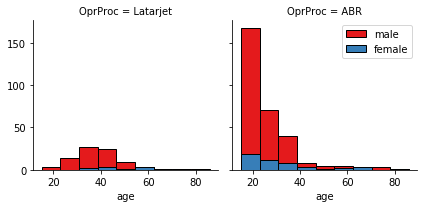

In [183]:
import seaborn as sns

bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="OprProc", hue="Gender", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

This plot shows distribution of surgeries by the weekday

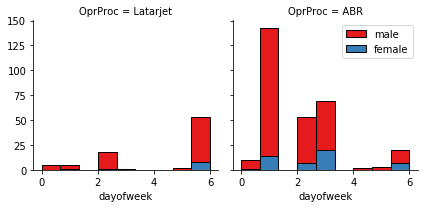

In [184]:
df['dayofweek'] = df['Date_hospitalization'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="OprProc", hue="Gender", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


## Outcomes measures

The following plot shows distribution of different ASES scores by gender and type of surgery. 

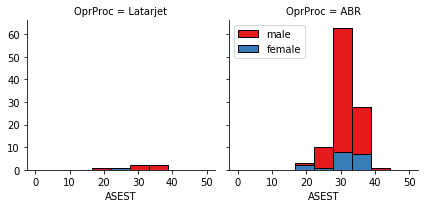

In [185]:
bins = np.linspace(0, 50, 10)
g = sns.FacetGrid(df, col="OprProc", hue="Gender", palette="Set1", col_wrap=2)
g.map(plt.hist, 'ASEST', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

## Replace all missing values with mean values of the corresponding surgery type group

For further analysis we will have to deal with missing data - replace it by mean outcomes of the respective surgery group

In [186]:
df['OprProc'].replace(to_replace=['ABR','Latarjet'], value=[0,1],inplace=True)
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

In [187]:
df = df.groupby(df['OprProc']).transform(lambda x: x.fillna(x.mean()))
#X=X.fillna(X.mean())

Outcomes after replacement of missing values

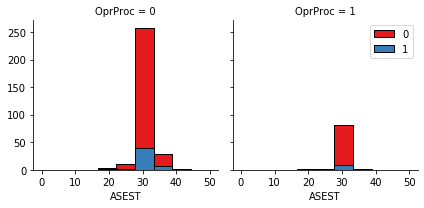

In [188]:
bins = np.linspace(0, 50, 10)
g = sns.FacetGrid(df, col="OprProc", hue="Gender", palette="Set1", col_wrap=2)
g.map(plt.hist, 'ASEST', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

In [189]:
df['OprProc'].replace(to_replace=[0,1], value=['ABR','Latarjet'],inplace=True)

In [190]:
df[['OprProc','age','ASEST','SFMT','SFPT','DASHT']].groupby(['OprProc']).mean()

,age,ASEST,SFMT,SFPT,DASHT
OprProc,,,,,
ABR,26.369628,31.317073,17.780488,12.308943,39.303279
Latarjet,39.686170,29.666667,16.166667,11.666667,44.000000


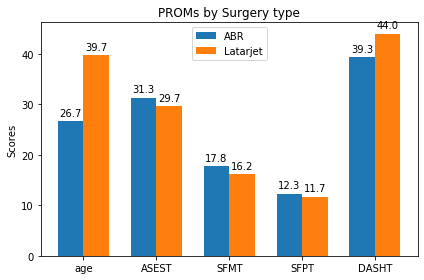

In [191]:
labels = ['age','ASEST','SFMT','SFPT','DASHT']
ABR_means = [26.7,31.3, 17.8, 12.3, 39.3]
Latarjet_means = [39.7, 29.7, 16.2, 11.7,44]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, ABR_means, width, label='ABR')
rects2 = ax.bar(x + width/2, Latarjet_means, width, label='Latarjet')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('PROMs by Surgery type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Until now we did not apply advanced methods of compound assessment of several outcome measures and identification of distinct patient groups. For these purposes we will apply clustering

## Select parameters for clustering

For this outcome group model we have selected:

1. Type of procedure
2. Gender
3. Age
4. ASES score
5. SF mental
6. SF physical
7. DASH score


In [192]:
X = df[['OprProc','age','Gender','ASEST','SFMT','SFPT','DASHT']]

Replace categorical values with numerical

In [193]:
X['OprProc'].replace(to_replace=['ABR','Latarjet'], value=[0,1],inplace=True)
#X['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

/home/stanok/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [194]:
X['OprProc'].value_counts()

0    349
1     94
Name: OprProc, dtype: int64

## One-hot encoding

In [195]:
X = pd.concat([X,pd.get_dummies(X['OprProc'])], axis=1)

In [196]:
#X = X[['ASEST','SFMT','SFPT','ABR','Latarjet']]
#X.head()

In [197]:
#X= preprocessing.StandardScaler().fit(X).transform(X)

Lets check distribution of outcomes using scatterplots

In [198]:
import seaborn as sns

In [199]:
paired = X[['OprProc','ASEST','SFMT','SFPT','DASHT']]

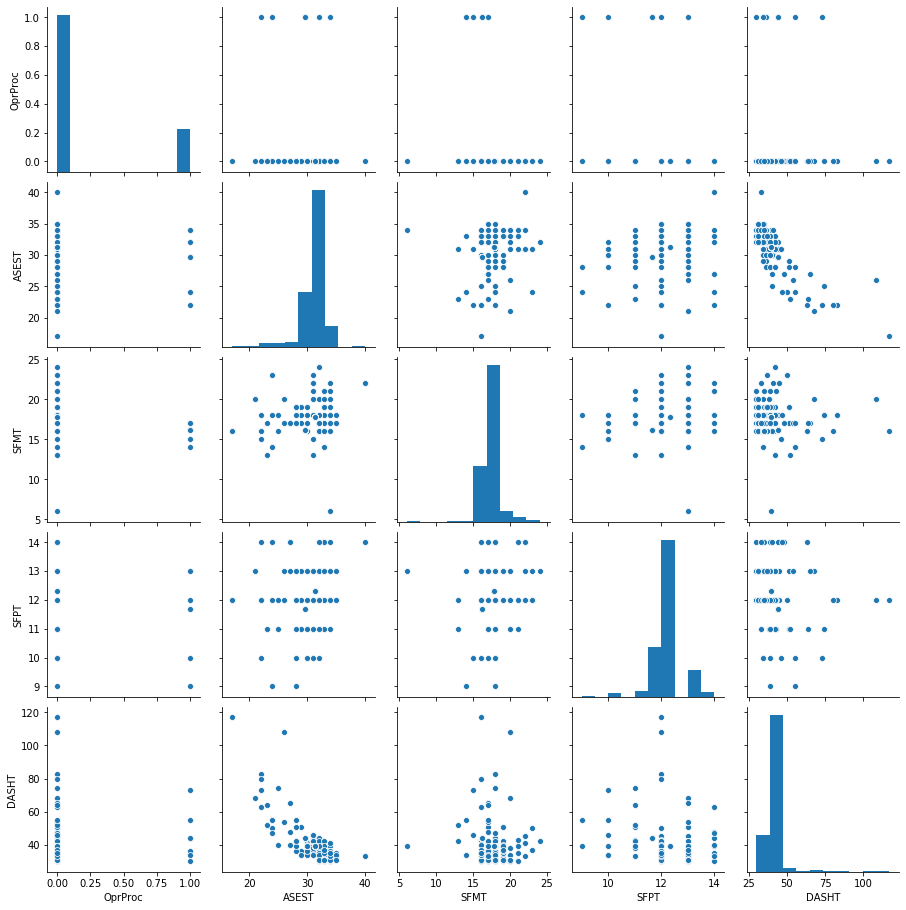

In [200]:
sns.pairplot(paired)

Three-dimensional plots may be evaluated for interdependence of the parameters

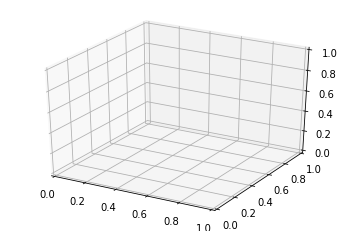

In [201]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')

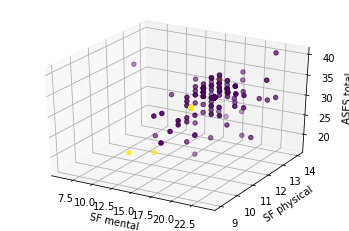

In [202]:
ax = plt.axes(projection='3d')
ax.scatter(X['SFMT'], X['SFPT'], X['ASEST'], c=X['OprProc'], cmap='viridis', linewidth=1)
ax.set_xlabel('SF mental')
ax.set_ylabel('SF physical')
ax.set_zlabel('ASES total')
plt.show()

In the plot above, yellow circles represent Latarjet cases whereas purple circles stand for ABR cases. Different transparency corresponds to "density" or number of cases with the same score. Next plots will demonstrate dependence between age and SF scores and DASH and SF scores

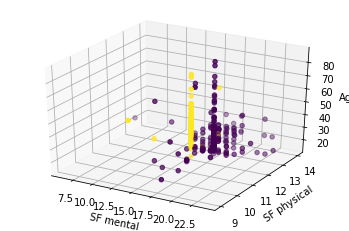

In [203]:
ax = plt.axes(projection='3d')
ax.scatter(X['SFMT'], X['SFPT'], X['age'], c=X['OprProc'], cmap='viridis', linewidth=1)
ax.set_xlabel('SF mental')
ax.set_ylabel('SF physical')
ax.set_zlabel('Age')
plt.show()

It appears that with increasing age the outcomes are more consistent. In this case, it ounly reflects that for most older individuals the outcome data was missing and was replaced with mean values

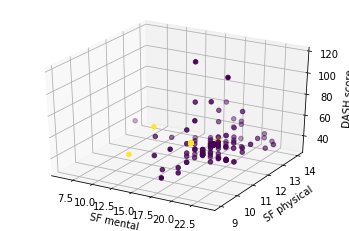

In [204]:
ax = plt.axes(projection='3d')
ax.scatter(X['SFMT'], X['SFPT'], X['DASHT'], c=X['OprProc'], cmap='viridis', linewidth=1)
ax.set_xlabel('SF mental')
ax.set_ylabel('SF physical')
ax.set_zlabel('DASH score')
plt.show()

## Clustering patients

In [205]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [206]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

First we will determine the optimal number of clusters

## Elbow plot

In [207]:
cost=[]
for i in range(1,11):
    KM=KMeans(n_clusters=i, max_iter=500).fit(X)
    cost.append(KM.inertia_)

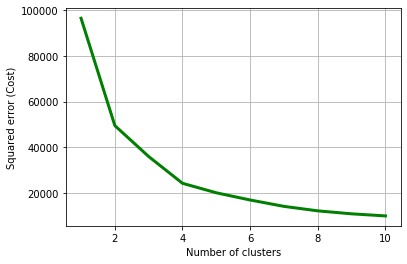

In [208]:
plt.plot(range(1,11),cost,color='g',linewidth='3')
plt.xlabel("Number of clusters")
plt.ylabel("Squared error (Cost)")
plt.grid()
plt.show()

In [209]:
model = KMeans(n_clusters=4).fit(X)

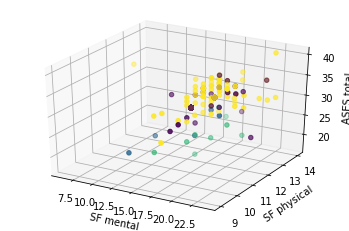

In [210]:
ax = plt.axes(projection='3d')
ax.scatter(X['SFMT'], X['SFPT'], X['ASEST'], c=model.labels_.astype(float), cmap='viridis', linewidth=1)
ax.set_xlabel('SF mental')
ax.set_ylabel('SF physical')
ax.set_zlabel('ASES total')
plt.show()

In [211]:
X['Cluster labels'] = model.labels_

In [212]:
X.rename(columns={'OprProc': 'Surgery'}, inplace=True)

In [213]:
X['Surgery'].replace(to_replace=[0,1], value=['ABR','Latarjet'],inplace=True)

In [214]:
X[['Surgery','age','ASEST','SFMT','SFPT','DASHT','Cluster labels']].groupby(['Cluster labels', 'Surgery']).mean()

age      ASEST       SFMT       SFPT      DASHT
Cluster labels Surgery                                                        
0              ABR       33.955224  31.183109  17.867492  12.297051  39.143993
               Latarjet  37.130769  29.666667  16.166667  11.666667  44.000000
1              ABR       61.684211  30.408216  17.721438  12.086008  41.713115
               Latarjet  57.833333  29.592593  16.092593  11.592593  43.833333
2              ABR       33.375000  22.500000  17.500000  12.375000  81.000000
               Latarjet  41.000000  22.000000  15.000000  10.000000  73.000000
3              ABR       21.525490  31.696604  17.770827  12.326606  37.857441
               Latarjet  23.500000  30.566667  16.416667  11.966667  41.400000

Presenting DASH scores by Surgery type and cluster

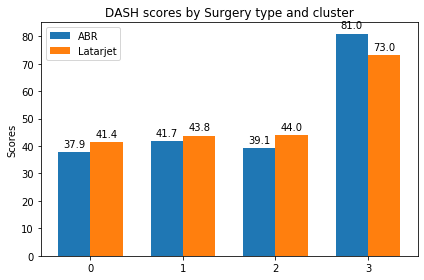

In [215]:
labels = ['0','1','2','3']
ABR_means = [37.9, 41.7, 39.1, 81]
Latarjet_means = [41.4, 43.8, 44, 73]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, ABR_means, width, label='ABR')
rects2 = ax.bar(x + width/2, Latarjet_means, width, label='Latarjet')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('DASH scores by Surgery type and cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Cluster 0 included the youngest group of patients, cluster 1 included older patients. SF-12 scores were similar between groups. Cluster 3 is interesting because they have worst outcome scores (DASH and ASEST), not related to age - they are of the same age as cluster 1 but cluster 1 have better outcomes.
We can further explore what's wrong with these patients by running additional comparisons between cluster 1 and 3.